# Exploring Dataset and Feature Engineering

In [137]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.cluster import KMeans
import zipfile
from pyproj import Proj, transform
import shapefile
from six import StringIO 
# a nice way of filtering out deprecated warnings
import warnings
warnings.filterwarnings("ignore")


## Saving Zone Information

In [8]:
dfzone = pd.read_csv("../raw_data/taxi+_zone_lookup.csv")

## Saving NYC Taxi Data

In [9]:
df2019 = pd.read_csv("../data/large/yellow_tripdata_2019-03.csv")
df20192 = pd.read_csv("../data/large/yellow_tripdata_2019-04.csv")
df20193 = pd.read_csv("../data/large/yellow_tripdata_2019-05.csv")

In [10]:
df2019.reset_index().to_feather('../data/lab_specific/df2019.feather')
df20192.reset_index().to_feather('../data/lab_specific/df20192.feather')
df20193.reset_index().to_feather('../data/lab_specific/df20193.feather')

In [11]:
df2019 = pd.read_feather('../data/lab_specific/df2019.feather')
df20192 = pd.read_feather('../data/lab_specific/df20192.feather')
df20193 = pd.read_feather('../data/lab_specific/df20193.feather')

The following code joins the data for each year

In [12]:
df_taxi = df2019.append(df20192, ignore_index = True)
df_taxi = df_taxi.append(df20193, ignore_index = True)

In [13]:
# reduce memory usage
del df2019
del df20192
del df20193

In [14]:
df_taxi.head()

,index,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,0,1,2019-03-01 00:24:41,2019-03-01 00:25:31,1,0.0,1,N,145,145,2,2.5,0.5,0.5,0.0,0.00,0.3,3.80,0.0
1,1,1,2019-03-01 00:25:27,2019-03-01 00:36:37,2,3.7,1,N,95,130,1,13.0,0.5,0.5,0.7,0.00,0.3,15.00,0.0
2,2,1,2019-03-01 00:05:21,2019-03-01 00:38:23,1,14.1,1,N,249,28,1,41.0,3.0,0.5,10.1,5.76,0.3,60.66,2.5
3,3,1,2019-03-01 00:48:55,2019-03-01 01:06:03,1,9.6,1,N,138,98,2,27.0,0.5,0.5,0.0,0.00,0.3,28.30,0.0
4,4,1,2019-03-01 00:11:42,2019-03-01 00:16:40,1,0.8,1,N,48,48,1,5.5,3.0,0.5,3.0,0.00,0.3,12.30,2.5


In [15]:
old_size= len(df_taxi)
old_size

22830945

### Convert datatypes to appropriate datatypes

In [16]:
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22830945 entries, 0 to 22830944
Data columns (total 19 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   index                  int64  
 1   VendorID               int64  
 2   tpep_pickup_datetime   object 
 3   tpep_dropoff_datetime  object 
 4   passenger_count        int64  
 5   trip_distance          float64
 6   RatecodeID             int64  
 7   store_and_fwd_flag     object 
 8   PULocationID           int64  
 9   DOLocationID           int64  
 10  payment_type           int64  
 11  fare_amount            float64
 12  extra                  float64
 13  mta_tax                float64
 14  tip_amount             float64
 15  tolls_amount           float64
 16  improvement_surcharge  float64
 17  total_amount           float64
 18  congestion_surcharge   float64
dtypes: float64(9), int64(7), object(3)
memory usage: 3.2+ GB


First, reduce memory usage by changing to appropriate data type

In [17]:

#convert to int8
for i in ['VendorID', 'RatecodeID', 'passenger_count','payment_type','PULocationID', 
          'DOLocationID']:
    df_taxi[i]= df_taxi[i].astype('int16')

#convert to float32
for i in [ 'trip_distance','fare_amount', 
          'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 
          'improvement_surcharge', 'total_amount',
          'congestion_surcharge']:
    df_taxi[i]= df_taxi[i].astype('float32')
    


As seen in the .info(), the datetime columns have a data type of an object, convert it to a datatime date type in order to access more features.

In [22]:
df_taxi['tpep_pickup_datetime']= pd.to_datetime(df_taxi['tpep_pickup_datetime'])
print("converted pickup to ", type(df_taxi['tpep_pickup_datetime'][0]))
df_taxi['tpep_dropoff_datetime']= pd.to_datetime(df_taxi['tpep_dropoff_datetime'])
print("converted dropoff to ", type(df_taxi['tpep_dropoff_datetime'][0]))

converted pickup to  <class 'pandas._libs.tslibs.timestamps.Timestamp'>
converted dropoff to  <class 'pandas._libs.tslibs.timestamps.Timestamp'>


### Delete the irrelevant columns

In [ ]:
df_taxi= df_taxi.drop(columns=['index', 'store_and_fwd_flag'])

In [ ]:
df_taxi.info()

Basic Intuitions based on columns:
    
    1. Date and Location feature will be relevant for the model that predicts taxi demand

### SUMMARY: Sorted Taxi Data Types for further cleaning

- Geographical data: PULocationID , DOLocationID
- Datatime data: tpep_pickup_datetime, tpep_dropoff_datetime
- Categorical Data: VendorID, RatecodeID, payment_type 
- Numerical Data: passenger_count, trip_distance, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surchage, total_amount, congestion_surcharge

## Save Uber Data

In [138]:
# Load CSV 
dffhv2019 = pd.read_csv("../data/large/fhvhv_tripdata_2019-03.csv")
dffhv20192 = pd.read_csv("../data/large/fhvhv_tripdata_2019-04.csv")
dffhv20193 = pd.read_csv("../data/large/fhvhv_tripdata_2019-05.csv")

dffhv2019.reset_index().to_feather("../data/fhvhv_tripdata_2019-03.feather")
dffhv20192.reset_index().to_feather("../data/fhvhv_tripdata_2019-04.feather")
dffhv20193.reset_index().to_feather("../data/fhvhv_tripdata_2019-05.feather")

dffhv2019 = pd.read_feather("../data/fhvhv_tripdata_2019-03.feather")
dffhv20192 = pd.read_feather("../data/fhvhv_tripdata_2019-04.feather")
dffhv20193 = pd.read_feather("../data/fhvhv_tripdata_2019-05.feather")

#The following code joins the data for each year

df_fhv = dffhv2019.append(dffhv20192, ignore_index = True)
df_fhv = df_fhv.append(dffhv20193, ignore_index = True)

In [141]:
# reduce memory usage
del dffhv2019
del dffhv20192
del dffhv20193

NameError: name 'dffhv2019' is not defined

In [142]:
print(df_fhv.shape)
df_fhv.head()

(67928519, 8)


,index,hvfhs_license_num,dispatching_base_num,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,SR_Flag
0,0,HV0004,B02800,2019-03-01 00:13:55,2019-03-01 00:28:51,36,80,1.0
1,1,HV0004,B02800,2019-03-01 00:23:58,2019-03-01 00:43:03,37,232,1.0
2,2,HV0005,B02510,2019-03-01 00:03:37,2019-03-01 00:15:09,25,62,NaN
3,3,HV0003,B02884,2019-03-01 00:29:46,2019-03-01 00:50:43,65,262,NaN
4,4,HV0003,B02884,2019-03-01 00:58:56,2019-03-01 01:20:47,140,196,NaN


In [143]:
old_size_fhv= len(df_fhv)

In [144]:
df_fhv.describe().round()

,index,PULocationID,DOLocationID,SR_Flag
count,67928519.0,67928519.0,67928519.0,12988111.0
mean,11339200.0,139.0,141.0,1.0
std,6567516.0,75.0,78.0,0.0
min,0.0,1.0,1.0,1.0
25%,5660710.0,74.0,75.0,1.0
50%,11321419.0,140.0,141.0,1.0
75%,16982129.0,211.0,216.0,1.0
max,23864597.0,265.0,265.0,1.0


### Check for Invalid Location ID

In [145]:
df_fhv.loc[df_fhv['PULocationID']<0]

,index,hvfhs_license_num,dispatching_base_num,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,SR_Flag


### Check Null Values

In [ ]:
print(df_fhv["SR_Flag"])

### Delete the irrelevant columns

In [ ]:
#check if there is missing entries
print(df_fhv.isnull().sum())

In [146]:
del df_fhv["index"]

In [147]:
del df_fhv["dispatching_base_num"]

In [148]:
del df_fhv["hvfhs_license_num"]

In [150]:
del df_fhv["SR_Flag"]

Since locationID is very relevant, the entries with missing locationID values should be removed. However, there is no need to remove any rows since there is no missing locationID data

### Convert datatypes to appropriate datatypes

In [151]:
df_fhv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67928519 entries, 0 to 67928518
Data columns (total 4 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   pickup_datetime   object
 1   dropoff_datetime  object
 2   PULocationID      int64 
 3   DOLocationID      int64 
dtypes: int64(2), object(2)
memory usage: 2.0+ GB


First, reduce memory usage for running 

In [152]:
#convert to Location IDs to int8
for i in ["PULocationID", "DOLocationID"]:
    df_fhv[i]= df_fhv[i].astype('int16')

As seen in the .info(), the datetime columns have a data type of an object, convert it to a datatime date type in order to access more features.

In [153]:
df_fhv['pickup_datetime']= pd.to_datetime(df_fhv['pickup_datetime'])
print("converted pickup to ", type(df_fhv['pickup_datetime'][0]))
df_fhv['dropoff_datetime']=  pd.to_datetime(df_fhv['dropoff_datetime'], errors = 'coerce')
print("converted dropoff to", type(df_fhv['dropoff_datetime'][0]))

converted pickup to  <class 'pandas._libs.tslibs.timestamps.Timestamp'>
converted dropoff to <class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [154]:
print(df_fhv['pickup_datetime'][0])
print(type(df_fhv['pickup_datetime'][0]))
print(df_fhv['dropoff_datetime'][0])
print(type(df_fhv['dropoff_datetime'][0]))

2019-03-01 00:13:55
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
2019-03-01 00:28:51
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [155]:
df_fhv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67928519 entries, 0 to 67928518
Data columns (total 4 columns):
 #   Column            Dtype         
---  ------            -----         
 0   pickup_datetime   datetime64[ns]
 1   dropoff_datetime  datetime64[ns]
 2   PULocationID      int16         
 3   DOLocationID      int16         
dtypes: datetime64[ns](2), int16(2)
memory usage: 1.3 GB


### SUMMARY: Sorted FHV Data Types for further cleaning
- Geographical data: PULocationID , DOLocationID
- Datatime data: pickup_datetime, dropoff_datetime

## Cleaning DateTime Data for Taxi and FHV datasets

### Remove invalid trips

Check for and remove invalid trips where there was a pickup after the dropoff. There cannot be a trip where there is 0 seconds trip since there is a minimum of 2.50 fee.

Taxi Dataset:

In [215]:
df_taxi.loc[df_taxi['tpep_pickup_datetime']>= df_taxi['tpep_dropoff_datetime']].count()

index                    0
VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
total_trip_duration      0
avespeed_mileshr         0
time session             0
date                     0
hour                     0
dtype: int64

In [157]:
df_taxi= df_taxi.loc[df_taxi['tpep_pickup_datetime']< df_taxi['tpep_dropoff_datetime']]

FHV Dataset:

In [158]:
df_fhv.loc[df_fhv['pickup_datetime']>= df_fhv['dropoff_datetime']].count()

pickup_datetime     80
dropoff_datetime    80
PULocationID        80
DOLocationID        80
dtype: int64

In [159]:
df_fhv= df_fhv.loc[df_fhv['pickup_datetime']< df_fhv['dropoff_datetime']]

## Adding DataTime related Features

### For Taxi Datasets

### Creating  total_trip_duration feature for Taxi and FHV
This is a feature that consists of the total trip duration in minutes


In [212]:
#Convert to seconds
df_taxi['total_trip_duration'] = (df_taxi['tpep_dropoff_datetime'] - df_taxi['tpep_pickup_datetime']).astype('timedelta64[s]')
#convert to minutes
df_taxi['total_trip_duration'] = df_taxi['total_trip_duration']/60


In [211]:
#Convert to seconds
df_fhv['total_trip_duration'] = (df_fhv['dropoff_datetime'] - df_fhv['pickup_datetime']).astype('timedelta64[s]')
#convert to minutes
df_fhv['total_trip_duration'] = df_fhv['total_trip_duration']/60


### Remove datetime outside of range for Taxi and FHV Data

In [160]:
date1= pd.Timestamp(datetime(2019, 3, 1))
date2= pd.Timestamp(datetime(2019, 5, 31))
# taxi
df_taxi= df_taxi.iloc[(df_taxi['tpep_pickup_datetime']).values> date1]
df_taxi= df_taxi.iloc[(df_taxi['tpep_pickup_datetime']).values< date2]
df_taxi= df_taxi.iloc[(df_taxi["tpep_dropoff_datetime"]).values> date1]
df_taxi= df_taxi.iloc[(df_taxi["tpep_dropoff_datetime"]).values< date2]
#fhv
df_fhv= df_fhv.iloc[(df_fhv['pickup_datetime']).values> date1]
df_fhv= df_fhv.iloc[(df_fhv['pickup_datetime']).values< date2]
df_fhv= df_fhv.iloc[(df_fhv["dropoff_datetime"]).values> date1]
df_fhv= df_fhv.iloc[(df_fhv["dropoff_datetime"]).values< date2]

### Create avespeed_ mileshr feature for Taxi Data
 This feature demonstrates speed of miles per hour (which is consistent with standard US speed measure). Lower average speed may be associated with traffic.

In [ ]:
df_taxi['avespeed_mileshr']= df_taxi['trip_distance'] / (df_taxi['total_trip_duration']/60)

### Create time session feature for Taxi and FHV dataset
Bin hours into time sessions
According to https://learnersdictionary.com/qa/parts-of-the-day-early-morning-late-morning-etc

In [161]:
df_taxi['time session']=pd.cut(df_taxi['tpep_pickup_datetime'].dt.hour, [0,5,12,17,21,24],labels=['Night','Morning','Afternoon','Evening', 'Night'],include_lowest=True, ordered=False)
df_fhv['time session']=pd.cut(df_fhv['pickup_datetime'].dt.hour, [0,5,12,17,21,24],labels=['Night','Morning','Afternoon','Evening', 'Night'],include_lowest=True, ordered=False)

In [162]:
df_fhv['time session']

0           Night
1           Night
2           Night
3           Night
4           Night
            ...  
67171187    Night
67171188    Night
67171189    Night
67171192    Night
67171193    Night
Name: time session, Length: 67160702, dtype: category
Categories (4, object): ['Afternoon', 'Evening', 'Morning', 'Night']

### Create date column

In [ ]:
df_taxi['date']= df_taxi['tpep_pickup_datetime'].dt.date

In [163]:
df_fhv['date']= df_fhv['pickup_datetime'].dt.date

### Create hour column

In [205]:
df_taxi['hour']= df_taxi['tpep_pickup_datetime'].dt.hour

In [206]:
df_fhv['hour']= df_fhv['pickup_datetime'].dt.hour

## Inspecting Numerical Data 

We won't be looking at the Uber Dataset in terms of data cleaning numerical data since there is no numerical data available.

In [218]:
numerical_data= ['passenger_count', 'trip_distance', 'fare_amount',
                 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
                 'improvement_surcharge', 'total_amount', 
                 'congestion_surcharge', 'total_trip_duration']
df_taxi[numerical_data].describe().round(1)


,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,total_trip_duration
count,21222770.0,21222770.0,21222770.0,21222770.0,21222770.0,21222770.0,21222770.0,21222770.0,21222770.0,21222770.0,21222770.0
mean,1.6,2.4,11.6,1.1,0.4,2.0,0.2,0.3,16.8,2.3,17.0
std,1.2,2.7,86.2,1.3,0.1,2.3,1.2,0.0,86.3,0.6,70.5
min,1.0,0.0,-447.0,-57.5,-0.5,-65.8,-11.5,-0.3,-450.3,-2.5,0.0
25%,1.0,1.0,6.5,0.0,0.5,0.0,0.0,0.3,11.3,2.5,6.6
50%,1.0,1.6,9.0,0.5,0.5,2.0,0.0,0.3,14.3,2.5,11.0
75%,2.0,2.9,14.0,2.5,0.5,2.9,0.0,0.3,19.8,2.5,17.6
max,9.0,401.4,395839.9,20.0,60.8,444.0,760.0,1.0,395841.2,2.8,27454.8


Observations based on testing df description:

- Negative fare amount, extra, tip_amount, toll_amounts, mta_tax and total amount exists. This could be due to refunds and can be considered to be deleted from data. Also, fare amount has to be at least 2.50 USD (https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page)
- Outlier->The maximum payments and distance seem to be excessive and large.
- Outlier-> The minimum trip distances should be greater than 0
- Median and mean is not always equal for certain attributes. This indicates that we are dealing with skewed dataset

### Remove Invalid Relevant Payments 

This is a relevant process since we are considering to add tip_amount as a feature

In [220]:
#This removes the negative payments, free rides, no passengers and 0 distance rides
df_taxi= df_taxi.loc[(df_taxi['fare_amount']>=2.5) &
                   (df_taxi['trip_distance']> 0) &
                    (df_taxi['tip_amount']>=0) &
                    (df_taxi['passenger_count']>0)&
                    (df_taxi['congestion_surcharge']> 0) & 
                    (df_taxi['total_trip_duration']> 1) &
                    (df_taxi['total_trip_duration']< 12*60), :]

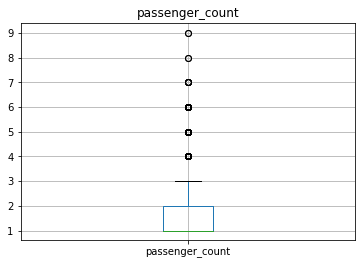

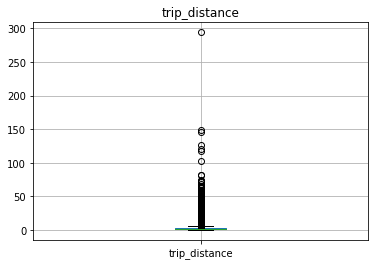

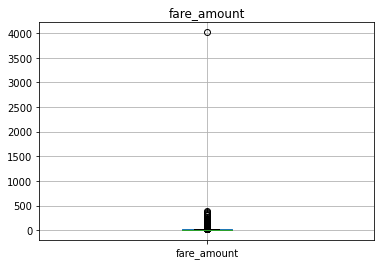

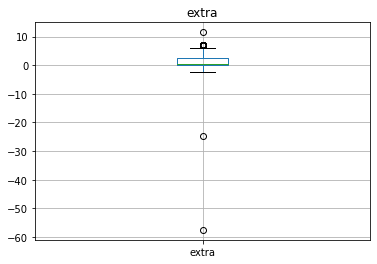

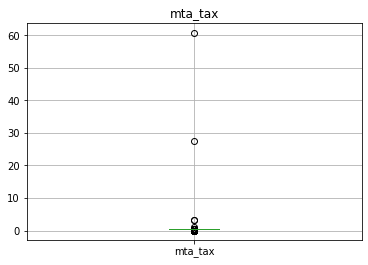

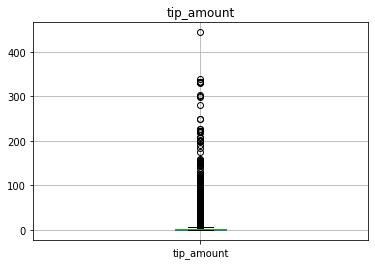

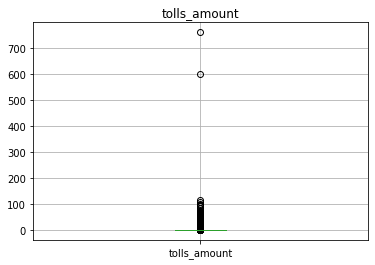

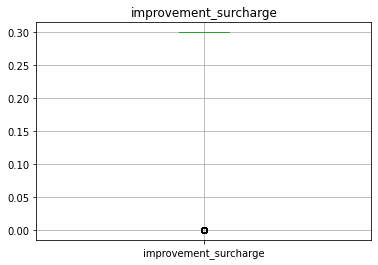

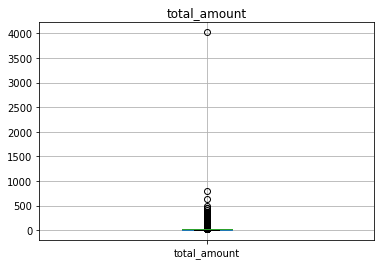

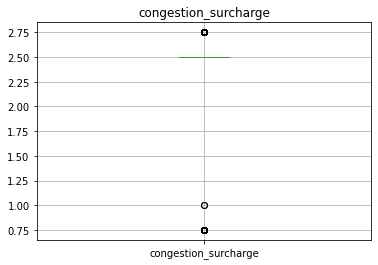

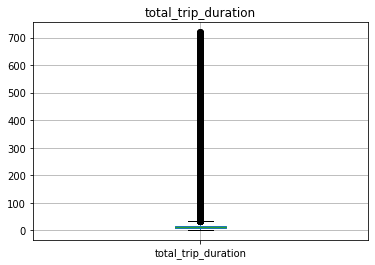

In [222]:
for i in numerical_data:
    df_taxi.boxplot(column= i)
    plt.title(i)
    plt.show()

In [224]:
df_fhv= df_fhv.loc[(df_fhv['passenger_count']>0)&
                    (df_fhv['total_trip_duration']> 1) &
                    (df_fhv['total_trip_duration']< 12*60), :]

### Create Passenger Count column for FHV Dataset
We are assuming that the passenger count is under a similar distribution as the taxi dataset. This is further backed up by the report indicating that uber passenger count mean is 1.75-2 matching with the summary we have indicating that passenger count mean is 1.6. (https://pantonium.com/some-uber-statistics/) 
However, in order to determine whether we are to use the median (1) or mean (2), we should calculate the percentage of taxi dataset where there is 1 passenger

Median and mean is not always equal for certain attributes. This indicates that we are dealing with skewed dataset

In [ ]:
len(df_taxi[df_taxi['passenger_count']==1])/df_taxi.shape[0]

Since 70% of the data is of one pessenger, we will use the median

In [173]:
df_fhv['passenger_count']=1

### Create FHV demand feature
This is in order to determine correlation with other attributes. This is done by grouping the taxi data by date, time of the day and location ID so there is 4 entries per day

In [ ]:
df_fhv['fhv demand for each entry']= df_fhv.groupby(['date', 'time session','PULocationID'], as_index= False)['passenger_count'].transform('sum')
df_fhv

In [ ]:
#https://www.netstate.com/states/geography/ny_geography.htm
df_taxi= df_taxi.loc[(df_taxi['trip_distance']<=613)]

In [36]:
#https://www.netstate.com/states/geography/ny_geography.htm
df_taxi= df_taxi.loc[(df_taxi['trip_distance']<=75)& 
                  (df_taxi['fare_amount']<=100) &
                  (df_taxi['tip_amount']<=150) &
                   (df_taxi['tolls_amount']<=60) &
                  (df_taxi['total_amount']<=300)]

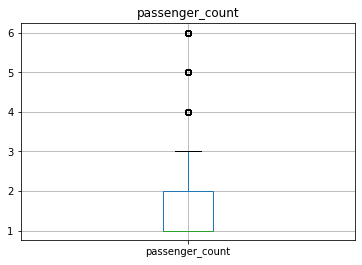

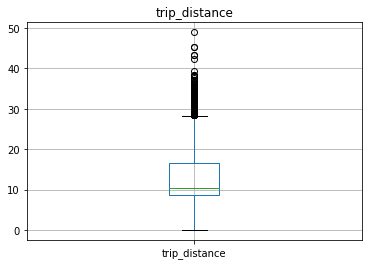

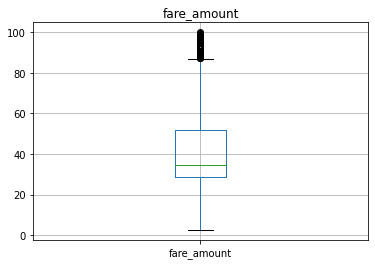

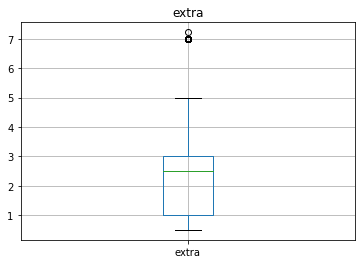

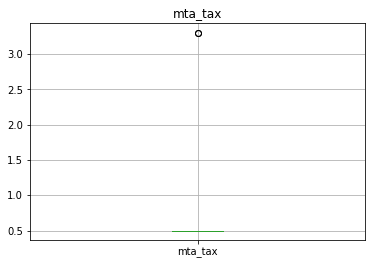

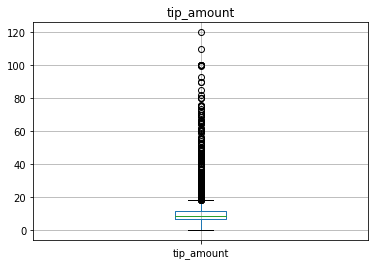

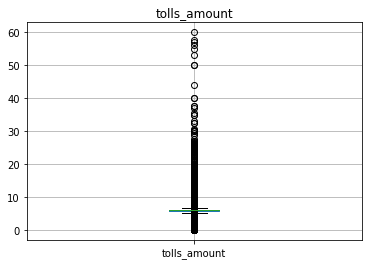

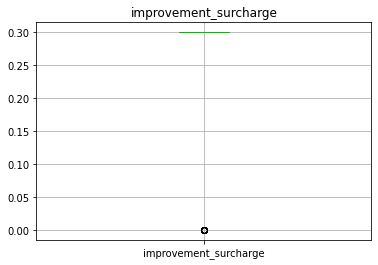

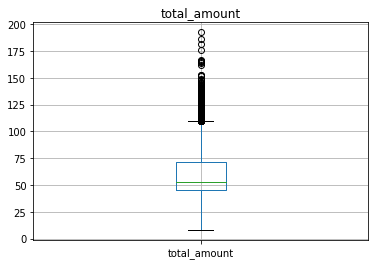

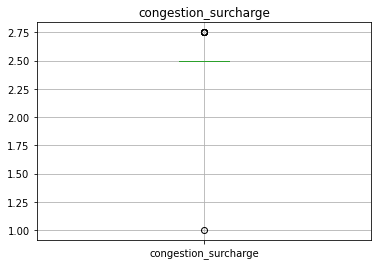

In [112]:
for i in numerical_data:
    df_taxi.boxplot(column= i)
    plt.title(i)
    plt.show()

Inference:
As expected, there is a correlation between fare amount and total amount. There is als a correlation between total_amount and tip_amount

### Create taxi demand feature
This is in order to determine correlation with other attributes. This is done by grouping the taxi data by date, time of the day and location ID so there is 4 entries per day. 

In [174]:
df_taxi['taxi demand for each entry']= df_taxi.groupby(['date', 'time session','PULocationID'], as_index= False)['passenger_count'].transform('sum')
df_taxi

,index,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,total_trip_duration,avespeed_mileshr,time session,date,taxi demand for each entry
0,0,1,2019-03-01 00:24:41,2019-03-01 00:25:31,1,0.00,1,N,145,145,...,0.00,0.00,0.3,3.800000,0.0,0.833333,0.000000,Night,2019-03-01,89
1,1,1,2019-03-01 00:25:27,2019-03-01 00:36:37,2,3.70,1,N,95,130,...,0.70,0.00,0.3,15.000000,0.0,11.166667,19.880597,Night,2019-03-01,13
2,2,1,2019-03-01 00:05:21,2019-03-01 00:38:23,1,14.10,1,N,249,28,...,10.10,5.76,0.3,60.660000,2.5,33.033333,25.610495,Night,2019-03-01,3247
3,3,1,2019-03-01 00:48:55,2019-03-01 01:06:03,1,9.60,1,N,138,98,...,0.00,0.00,0.3,28.299999,0.0,17.133333,33.618678,Night,2019-03-01,1769
4,4,1,2019-03-01 00:11:42,2019-03-01 00:16:40,1,0.80,1,N,48,48,...,3.00,0.00,0.3,12.300000,2.5,4.966667,9.664430,Night,2019-03-01,4210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22811895,7546211,2,2019-05-30 12:11:04,2019-05-30 12:14:33,1,0.42,1,N,239,142,...,1.66,0.00,0.3,9.960000,2.5,3.483333,7.234450,Morning,2019-05-30,3273
22811896,7546212,2,2019-05-30 12:17:52,2019-05-30 12:43:29,1,4.99,1,N,142,112,...,0.00,0.00,0.3,24.299999,2.5,25.616667,11.687703,Morning,2019-05-30,3452
22826072,7560388,2,2019-05-30 13:27:39,2019-05-30 13:56:27,1,2.69,1,N,229,113,...,2.23,0.00,0.3,24.530001,2.5,28.800000,5.604167,Afternoon,2019-05-30,1682
22826073,7560389,2,2019-05-30 13:58:00,2019-05-30 14:00:20,1,0.54,1,N,113,113,...,1.95,0.00,0.3,9.750000,2.5,2.333333,13.885715,Afternoon,2019-05-30,1294


<AxesSubplot:>

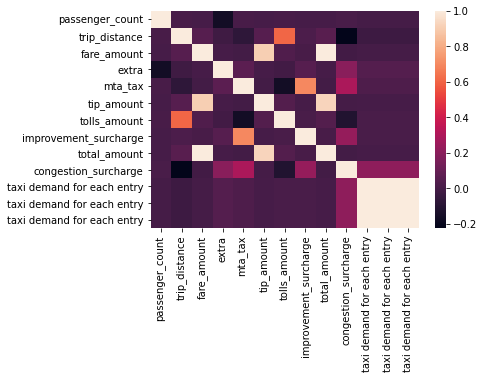

In [175]:
numerical_data.append('taxi demand for each entry')
sns.heatmap(df_taxi[numerical_data].corr())

Interesting, how congestion charge is related to taxi demand. This could be used in the final model. Unexpectedly, there seems to be nearly 0 correlation between taxi demand and tip amount. 

In [225]:
df_taxi[numerical_data].describe().round(1)

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,total_trip_duration
count,19555317.0,19555317.0,19555317.0,19555317.0,19555317.0,19555317.0,19555317.0,19555317.0,19555317.0,19555317.0,19555317.0
mean,1.6,2.2,11.2,1.1,0.4,2.1,0.2,0.3,16.8,2.5,13.3
std,1.2,2.3,7.2,1.3,0.1,2.1,1.1,0.0,9.0,0.0,10.1
min,1.0,0.0,2.5,-57.5,0.0,0.0,0.0,0.0,3.8,0.8,1.0
25%,1.0,1.0,6.5,0.0,0.5,0.0,0.0,0.3,11.3,2.5,6.7
50%,1.0,1.6,9.0,0.5,0.5,2.0,0.0,0.3,14.6,2.5,10.9
75%,2.0,2.7,13.5,2.5,0.5,3.0,0.0,0.3,19.5,2.5,17.2
max,9.0,294.1,4016.5,11.5,60.8,444.0,760.0,0.3,4020.3,2.8,719.6


## Cleaning Categorical Data

In [195]:
categorical_data= ['VendorID', 'RatecodeID', 'payment_type']

In [177]:
#Check if the values align with the values given with the 
# data details
for i in categorical_data:
    print(i+ ':',df_taxi[i].value_counts().index)

VendorID: Int64Index([2, 1, 4], dtype='int64')
RatecodeID: Int64Index([1, 2, 5, 3, 4, 99, 6], dtype='int64')
payment_type: Int64Index([1, 2, 3, 4], dtype='int64')


Since VendorID is an irrelevant feature, we wouldn't need to remove the invalid ID of 4 since the rest of the features of the entries may be valid.
For RatecodeID, there is an invalid RatecodeID of 99. Since we want only want standard rides to predict for typical demand, this should be removed.
Before we remove these values, we should inspect the distribution of categorial data

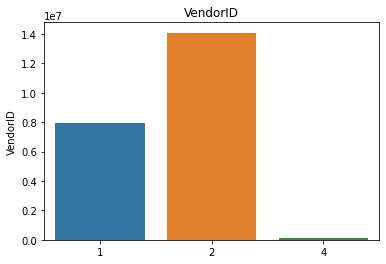

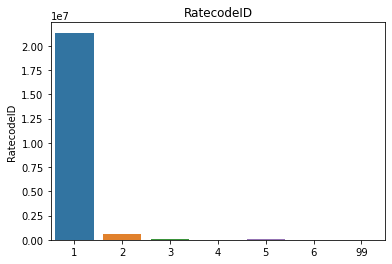

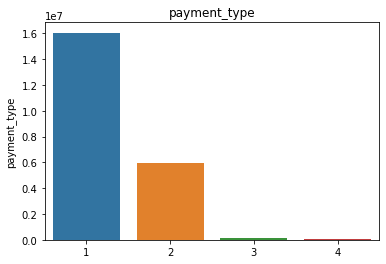

In [178]:
for i in categorical_data:
    sns.barplot(df_taxi[i].value_counts().index, df_taxi[i].value_counts())
    plt.title(i)
    plt.show()

The plot tells us that majority of the data lies in the standard rate with payment mostly being through cash or card

In [185]:
df_taxi= df_taxi.loc[df_taxi["RatecodeID"]==1]
df_taxi=  df_taxi.loc[df_taxi["payment_type"]<=2]

### Saving Data

In [210]:
df_taxi.to_csv()

,index,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,total_trip_duration,avespeed_mileshr,time session,date,hour
0,0,1,2019-03-01 00:24:41,2019-03-01 00:25:31,1,0.00,1,N,145,145,...,0.00,0.00,0.3,3.800000,0.0,0.833333,0.000000,Night,2019-03-01,0
1,1,1,2019-03-01 00:25:27,2019-03-01 00:36:37,2,3.70,1,N,95,130,...,0.70,0.00,0.3,15.000000,0.0,11.166667,19.880597,Night,2019-03-01,0
2,2,1,2019-03-01 00:05:21,2019-03-01 00:38:23,1,14.10,1,N,249,28,...,10.10,5.76,0.3,60.660000,2.5,33.033333,25.610495,Night,2019-03-01,0
3,3,1,2019-03-01 00:48:55,2019-03-01 01:06:03,1,9.60,1,N,138,98,...,0.00,0.00,0.3,28.299999,0.0,17.133333,33.618678,Night,2019-03-01,0
4,4,1,2019-03-01 00:11:42,2019-03-01 00:16:40,1,0.80,1,N,48,48,...,3.00,0.00,0.3,12.300000,2.5,4.966667,9.664430,Night,2019-03-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22811895,7546211,2,2019-05-30 12:11:04,2019-05-30 12:14:33,1,0.42,1,N,239,142,...,1.66,0.00,0.3,9.960000,2.5,3.483333,7.234450,Morning,2019-05-30,12
22811896,7546212,2,2019-05-30 12:17:52,2019-05-30 12:43:29,1,4.99,1,N,142,112,...,0.00,0.00,0.3,24.299999,2.5,25.616667,11.687703,Morning,2019-05-30,12
22826072,7560388,2,2019-05-30 13:27:39,2019-05-30 13:56:27,1,2.69,1,N,229,113,...,2.23,0.00,0.3,24.530001,2.5,28.800000,5.604167,Afternoon,2019-05-30,13
22826073,7560389,2,2019-05-30 13:58:00,2019-05-30 14:00:20,1,0.54,1,N,113,113,...,1.95,0.00,0.3,9.750000,2.5,2.333333,13.885715,Afternoon,2019-05-30,13


In [186]:
df_taxi.shape

(21222770, 24)

In [208]:
df_fhv

,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,time session,date,passenger_count,hour
0,2019-03-01 00:13:55,2019-03-01 00:28:51,36,80,Night,2019-03-01,1,0
1,2019-03-01 00:23:58,2019-03-01 00:43:03,37,232,Night,2019-03-01,1,0
2,2019-03-01 00:03:37,2019-03-01 00:15:09,25,62,Night,2019-03-01,1,0
3,2019-03-01 00:29:46,2019-03-01 00:50:43,65,262,Night,2019-03-01,1,0
4,2019-03-01 00:58:56,2019-03-01 01:20:47,140,196,Night,2019-03-01,1,0
...,...,...,...,...,...,...,...,...
67171187,2019-05-30 23:35:25,2019-05-30 23:54:53,42,239,Night,2019-05-30,1,23
67171188,2019-05-30 23:22:09,2019-05-30 23:32:34,230,141,Night,2019-05-30,1,23
67171189,2019-05-30 23:37:38,2019-05-30 23:52:22,141,146,Night,2019-05-30,1,23
67171192,2019-05-30 23:04:32,2019-05-30 23:32:15,126,162,Night,2019-05-30,1,23


In [200]:
df_taxi_demand = df_taxi.groupby(['date', 'time session','PULocationID'], as_index= False)['passenger_count'].sum()

In [204]:
df_fhv

,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,time session,date,passenger_count
0,2019-03-01 00:13:55,2019-03-01 00:28:51,36,80,Night,2019-03-01,1
1,2019-03-01 00:23:58,2019-03-01 00:43:03,37,232,Night,2019-03-01,1
2,2019-03-01 00:03:37,2019-03-01 00:15:09,25,62,Night,2019-03-01,1
3,2019-03-01 00:29:46,2019-03-01 00:50:43,65,262,Night,2019-03-01,1
4,2019-03-01 00:58:56,2019-03-01 01:20:47,140,196,Night,2019-03-01,1
...,...,...,...,...,...,...,...
67171187,2019-05-30 23:35:25,2019-05-30 23:54:53,42,239,Night,2019-05-30,1
67171188,2019-05-30 23:22:09,2019-05-30 23:32:34,230,141,Night,2019-05-30,1
67171189,2019-05-30 23:37:38,2019-05-30 23:52:22,141,146,Night,2019-05-30,1
67171192,2019-05-30 23:04:32,2019-05-30 23:32:15,126,162,Night,2019-05-30,1


In [201]:
df_taxi_demand

,date,time session,PULocationID,passenger_count
0,2019-03-01,Afternoon,1,0
1,2019-03-01,Afternoon,2,0
2,2019-03-01,Afternoon,3,2
3,2019-03-01,Afternoon,4,84
4,2019-03-01,Afternoon,5,0
...,...,...,...,...
95363,2019-05-30,Night,261,191
95364,2019-05-30,Night,262,237
95365,2019-05-30,Night,263,773
95366,2019-05-30,Night,264,617


Dealing with FHV dataset

In [202]:
df_fhv_demand= df_fhv.groupby(['date', 'time session','PULocationID'], as_index= False)['passenger_count'].sum()

In [199]:
df_taxi_grouped= df_taxi.groupby(['date', 'time session','PULocationID'], as_index= False).median()
df_taxi_grouped.dropna()


,date,time session,PULocationID,index,VendorID,passenger_count,trip_distance,RatecodeID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,total_trip_duration,avespeed_mileshr
2,2019-03-01,Afternoon,3,161056.5,1.5,1.0,1.585,1.0,107.5,1.5,7.50,0.5,0.5,0.000,0.0,0.3,8.800000,0.0,7.775000,12.138783
3,2019-03-01,Afternoon,4,150847.0,2.0,1.0,1.410,1.0,144.0,1.0,8.50,1.0,0.5,1.000,0.0,0.3,13.300000,2.5,9.850000,8.715790
6,2019-03-01,Afternoon,7,141439.5,2.0,1.0,1.500,1.0,145.5,2.0,8.00,0.0,0.5,0.000,0.0,0.3,9.330000,0.0,10.041667,9.294017
7,2019-03-01,Afternoon,8,117753.0,1.0,1.0,0.600,1.0,223.0,2.0,4.50,0.0,0.5,0.000,0.0,0.3,5.300000,0.0,3.000000,12.000000
8,2019-03-01,Afternoon,9,141588.5,2.0,1.0,7.215,1.0,172.5,1.5,22.75,0.5,0.5,0.000,0.0,0.3,24.049999,0.0,19.000000,25.902460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95363,2019-05-30,Night,261,7283592.5,2.0,1.0,3.810,1.0,146.5,1.0,15.75,0.5,0.5,2.750,0.0,0.3,21.879999,2.5,16.008333,16.011458
95364,2019-05-30,Night,262,7282035.0,2.0,1.0,1.700,1.0,162.0,1.0,8.00,0.5,0.5,1.665,0.0,0.3,13.300000,2.5,8.033333,14.541741
95365,2019-05-30,Night,263,7283434.5,2.0,1.0,1.830,1.0,143.5,1.0,8.00,0.5,0.5,1.760,0.0,0.3,13.560000,2.5,7.500000,14.968358
95366,2019-05-30,Night,264,7284540.0,2.0,1.0,2.080,1.0,264.0,1.0,9.00,0.5,0.5,1.960,0.0,0.3,14.750000,2.5,9.483333,13.363637


In [203]:
df_fhv_demand

,date,time session,PULocationID,passenger_count
0,2019-03-01,Afternoon,1,9
1,2019-03-01,Afternoon,2,0
2,2019-03-01,Afternoon,3,379
3,2019-03-01,Afternoon,4,644
4,2019-03-01,Afternoon,5,53
...,...,...,...,...
95727,2019-05-30,Night,261,372
95728,2019-05-30,Night,262,363
95729,2019-05-30,Night,263,761
95730,2019-05-30,Night,264,0


In [192]:
df_fhv_grouped= df_fhv.groupby(['date', 'time session','PULocationID'], as_index= False).median()
df_fhv_grouped.dropna()

,date,time session,PULocationID,DOLocationID,passenger_count
0,2019-03-01,Afternoon,1,143.0,1.0
2,2019-03-01,Afternoon,3,159.0,1.0
3,2019-03-01,Afternoon,4,137.5,1.0
4,2019-03-01,Afternoon,5,100.0,1.0
5,2019-03-01,Afternoon,6,151.5,1.0
...,...,...,...,...,...
95726,2019-05-30,Night,260,138.0,1.0
95727,2019-05-30,Night,261,138.0,1.0
95728,2019-05-30,Night,262,141.0,1.0
95729,2019-05-30,Night,263,141.0,1.0


In [119]:
temp= df_taxi.loc[df_taxi['date']== pd.Timestamp(datetime(2019, 3, 1))]
temp= temp.loc[temp['time session']=="Afternoon"]
temp= temp.loc[temp['PULocationID']==1]
temp

,index,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,total_trip_duration,avespeed_mileshr,time session,date,taxi demand for each entry
110572,110572,1,2019-03-01 13:28:13,2019-03-01 13:28:35,1,0.0,5,N,1,1,...,19.049999,0.0,0.3,114.349998,0.0,0.366667,0.0,Afternoon,2019-03-01,22
119756,119756,1,2019-03-01 13:22:43,2019-03-01 13:23:04,1,0.0,5,N,1,1,...,24.450001,27.1,0.3,146.850006,0.0,0.350000,0.0,Afternoon,2019-03-01,22
126571,126571,2,2019-03-01 14:12:13,2019-03-01 14:12:19,4,0.0,5,N,1,1,...,20.160000,0.0,0.3,120.959999,0.0,0.100000,0.0,Afternoon,2019-03-01,22
134927,134927,2,2019-03-01 14:32:29,2019-03-01 14:32:32,4,0.0,5,N,1,1,...,25.160000,0.0,0.3,150.960007,0.0,0.050000,0.0,Afternoon,2019-03-01,22
144799,144799,2,2019-03-01 15:38:20,2019-03-01 15:42:14,1,0.0,5,N,1,264,...,0.000000,0.0,-0.3,-101.309998,0.0,3.900000,0.0,Afternoon,2019-03-01,22
144800,144800,2,2019-03-01 15:38:20,2019-03-01 15:42:14,1,0.0,5,N,1,264,...,0.000000,0.0,0.3,101.309998,0.0,3.900000,0.0,Afternoon,2019-03-01,22
151983,151983,2,2019-03-01 15:25:29,2019-03-01 15:26:08,9,0.0,5,N,1,1,...,0.000000,0.0,0.3,95.300003,0.0,0.650000,0.0,Afternoon,2019-03-01,22
159242,159242,2,2019-03-01 16:12:08,2019-03-01 16:12:14,1,0.0,5,N,1,1,...,17.070000,0.0,0.3,102.430000,0.0,0.100000,0.0,Afternoon,2019-03-01,22


### Creating  total_trip_duration feature for Taxi
This is a feature that consists of the total trip duration in minutes


## Check Location Zone Data

In [396]:
dfzone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   LocationID    265 non-null    int64 
 1   Borough       265 non-null    object
 2   Zone          264 non-null    object
 3   service_zone  263 non-null    object
dtypes: int64(1), object(3)
memory usage: 8.4+ KB


In [397]:
dfzone.describe()

,LocationID
count,265.000000
mean,133.000000
std,76.643112
min,1.000000
25%,67.000000
50%,133.000000
75%,199.000000
max,265.000000


In [398]:
from sridentify import Sridentify
ident = Sridentify()
# from file
ident.from_file("../data/large/taxi_zones.prj")
ident.get_epsg()

2263

In [399]:
# the following code was borrowed from https://chih-ling-hsu.github.io/2018/05/14/NYC

def convert_to_longlat_type(x,y):
    inProj = Proj(init='epsg:2263')
    outProj = Proj(init='epsg:4326')
    return transform(inProj,outProj,x,y)

def get_lat_lon(sf):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        long_x, lat_y= convert_to_longlat_type(x,y)
        content.append((loc_id, long_x, lat_y))
        
    return pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"])

In [400]:
# the following code was borrowed from https://chih-ling-hsu.github.io/2018/05/14/NYC
print(dfzoneshp.fields)
dfzoneshp.fields[1:]

[('DeletionFlag', 'C', 1, 0), ['OBJECTID', 'N', 9, 0], ['Shape_Leng', 'F', 19, 11], ['Shape_Area', 'F', 19, 11], ['zone', 'C', 254, 0], ['LocationID', 'N', 4, 0], ['borough', 'C', 254, 0]]


[['OBJECTID', 'N', 9, 0],
 ['Shape_Leng', 'F', 19, 11],
 ['Shape_Area', 'F', 19, 11],
 ['zone', 'C', 254, 0],
 ['LocationID', 'N', 4, 0],
 ['borough', 'C', 254, 0]]

In [401]:
 #remove deletion flag and save feature names
fields_name = [field[0] for field in dfzoneshp.fields[1:]]
#make a dict with the features and the column number
dfzoneshp_dic = dict(zip(fields_name, list(range(len(fields_name)))))

#Save records into dictionary
records = sf.records()
dfzoneshp_records = [dict(zip(fields_name, rec)) for rec in records]
#join the data into a df along with the longitude and latitude
dfzoneloc = pd.DataFrame(dfzoneshp_records).join(get_lat_lon(dfzoneshp).set_index("LocationID"), on="LocationID")
dfzoneloc.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,-74.171526,40.689488
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,-73.822490,40.610791
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,-73.844947,40.865745
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,-73.977726,40.724137
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,-74.187537,40.550665


### Join Location data and Information data

In [402]:
print(dfzoneloc.shape)
dfzoneloc[dfzoneloc['LocationID'].duplicated(keep=False) == True]

(271, 8)


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
55,56,0.056848,0.000181,Corona,56,Queens,-73.857709,40.741565
55,56,0.056848,0.000181,Corona,56,Queens,-73.853347,40.751980
56,57,0.019271,0.000018,Corona,56,Queens,-73.857709,40.741565
56,57,0.019271,0.000018,Corona,56,Queens,-73.853347,40.751980
102,103,0.014306,0.000006,Governor's Island/Ellis Island/Liberty Island,103,Manhattan,-74.045142,40.689819
102,103,0.014306,0.000006,Governor's Island/Ellis Island/Liberty Island,103,Manhattan,-74.040693,40.698672
102,103,0.014306,0.000006,Governor's Island/Ellis Island/Liberty Island,103,Manhattan,-74.019189,40.688135
103,104,0.021221,0.000012,Governor's Island/Ellis Island/Liberty Island,103,Manhattan,-74.045142,40.689819
103,104,0.021221,0.000012,Governor's Island/Ellis Island/Liberty Island,103,Manhattan,-74.040693,40.698672
103,104,0.021221,0.000012,Governor's Island/Ellis Island/Liberty Island,103,Manhattan,-74.019189,40.688135


In [403]:
dfzoneloc= dfzoneloc.drop_duplicates(subset=['LocationID'])

In [404]:
print(dfzoneloc.shape)
dfzoneloc[dfzoneloc['LocationID'].duplicated(keep=False) == True]


(260, 8)


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude


Since there are no more duplicates and the location ID matches the location ID column in dfzone, dfzone.loc 

In [405]:
dfzone= dfzone.join(dfzoneloc[['longitude', 'latitude']], on= 'LocationID', how= "left")

In [507]:
del dfzoneloc

In [406]:
dfzone.head()

,LocationID,Borough,Zone,service_zone,longitude,latitude
0,1,EWR,Newark Airport,EWR,-73.822490,40.610791
1,2,Queens,Jamaica Bay,Boro Zone,-73.844947,40.865745
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone,-73.977726,40.724137
3,4,Manhattan,Alphabet City,Yellow Zone,-74.187537,40.550665
4,5,Staten Island,Arden Heights,Boro Zone,-74.072564,40.599047


### Check for Duplicates

In [407]:
print("There is duplicates. This statement is:", dfzone.duplicated(subset=['Borough', 'Zone', 'service_zone']).any())
dfzone[dfzone[['Borough', 'Zone', 'service_zone']].duplicated(keep=False) == True]

There is duplicates. This statement is: True


,LocationID,Borough,Zone,service_zone,longitude,latitude
55,56,Queens,Corona,Boro Zone,NaN,NaN
56,57,Queens,Corona,Boro Zone,-73.818980,40.841493
102,103,Manhattan,Governor's Island/Ellis Island/Liberty Island,Yellow Zone,NaN,NaN
103,104,Manhattan,Governor's Island/Ellis Island/Liberty Island,Yellow Zone,NaN,NaN
104,105,Manhattan,Governor's Island/Ellis Island/Liberty Island,Yellow Zone,-73.990188,40.673258


In [408]:
#Checking Location ID 56 and 57
print("The number of trips with PUlocation ID of 56 is", len(df_tot.loc[df_tot['PULocationID']== 56]))
print("The number of trips with PUlocation ID of 57 is", len(df_tot.loc[df_tot['PULocationID']== 57]))
#Checking location ID 103,104,105
print("The number of trips with PUlocation ID of 103 is", len(df_tot.loc[df_tot['PULocationID']== 103]))
print("The number of trips with PUlocation ID of 104 is", len(df_tot.loc[df_tot['PULocationID']== 104]))
print("The number of trips with PUlocation ID of 105 is", len(df_tot.loc[df_tot['PULocationID']== 105]))

The number of trips with PUlocation ID of 56 is 180
The number of trips with PUlocation ID of 57 is 0
The number of trips with PUlocation ID of 103 is 0
The number of trips with PUlocation ID of 104 is 0
The number of trips with PUlocation ID of 105 is 0


Since there is only 3 PULocationID from area 57. It is safe to assume that there may have been a mistake and the same location was matched to a locationID twice. Hence, all trips from locationid 57 will be marked as 56.
As for the the last 3 locationsIDs,it is safe to delete the values since there is 0 matches to our data.

In [409]:
df_tot.loc[df_tot['PULocationID']== 57] = 56
df_tot.loc[df_tot['DOLocationID']== 57] = 56
dfzone.drop([102, 103, 104])

,LocationID,Borough,Zone,service_zone,longitude,latitude
0,1,EWR,Newark Airport,EWR,-73.822490,40.610791
1,2,Queens,Jamaica Bay,Boro Zone,-73.844947,40.865745
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone,-73.977726,40.724137
3,4,Manhattan,Alphabet City,Yellow Zone,-74.187537,40.550665
4,5,Staten Island,Arden Heights,Boro Zone,-74.072564,40.599047
...,...,...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone,-73.945142,40.776681
261,262,Manhattan,Yorkville East,Yellow Zone,-73.951009,40.778766
262,263,Manhattan,Yorkville West,Yellow Zone,NaN,NaN
263,264,Unknown,NV,NaN,NaN,NaN


### Delete Invalid Zones

Remove the last two invalid entries and any other similar entries

In [410]:
dfzone.loc[dfzone["Borough"]=='Unknown']

,LocationID,Borough,Zone,service_zone,longitude,latitude
263,264,Unknown,NV,NaN,NaN,NaN
264,265,Unknown,NaN,NaN,NaN,NaN


Check for and remove invalid trips where there was a pickup after the dropoff. There cannot be a trip where there is 0 seconds trip since there is a minimum of 2.50 fee

In [411]:
dfzone.drop([263, 264])

,LocationID,Borough,Zone,service_zone,longitude,latitude
0,1,EWR,Newark Airport,EWR,-73.822490,40.610791
1,2,Queens,Jamaica Bay,Boro Zone,-73.844947,40.865745
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone,-73.977726,40.724137
3,4,Manhattan,Alphabet City,Yellow Zone,-74.187537,40.550665
4,5,Staten Island,Arden Heights,Boro Zone,-74.072564,40.599047
...,...,...,...,...,...,...
258,259,Bronx,Woodlawn/Wakefield,Boro Zone,-73.906841,40.746605
259,260,Queens,Woodside,Boro Zone,-74.012644,40.709120
260,261,Manhattan,World Trade Center,Yellow Zone,-73.945142,40.776681
261,262,Manhattan,Yorkville East,Yellow Zone,-73.951009,40.778766


In [538]:
df_tot_uber.loc[df_tot_uber['pickup_datetime']>= df_tot_uber['dropoff_datetime']].count()

dispatching_base_num    0
pickup_datetime         0
dropoff_datetime        0
PULocationID            0
DOLocationID            0
PUdatetime              0
DOdatetime              0
dtype: int64

In [412]:
dfzone= dfzone.drop_duplicates(subset=['Borough', 'Zone', 'service_zone'])

Before:  (265, 6)
After:  (262, 6)


### Delete where there is no location details

In [413]:
dfzone= dfzone.loc[dfzone["longitude"].notna()]
dfzone= dfzone.loc[dfzone["latitude"].notna()]

Delete the entries from uber and the taxi dataset that don't have a location

In [422]:
locationID_list= list(dfzone["LocationID"])
maximum_locID= max(df_tot.max()['PULocationID'], df_tot_uber.max()['PULocationID'])
maximum_locID= max(maximum_locID, df_tot.max()['DOLocationID'])
maximum_locID= max(maximum_locID, df_tot_uber.max()['DOLocationID'])

for i in range(1,int(maximum_locID)):
    if i not in locationID_list:
        if df_tot.loc[df_tot['PULocationID']==i].shape[0]>0:
            df_tot= df_tot.loc[df_tot['PULocationID']!=i]
        if df_tot.loc[df_tot['DOLocationID']==i].shape[0]>0:
            df_tot= df_tot.loc[df_tot['DOLocationID']!=i]
        if df_tot_uber.loc[df_tot_uber['PULocationID']==i].shape[0]>0:
            df_tot_uber= df_tot_uber.loc[df_tot_uber['PULocationID']!=i]
        if df_tot_uber.loc[df_tot_uber['DOLocationID']==i].shape[0]>0:
            df_tot_uber= df_tot_uber.loc[df_tot_uber['DOLocationID']!=i]
    
    

## Saving Weather Data

In [519]:
dfweather = pd.read_csv("../data/large/weather_data_3-5_2019.csv")
dfweather.reset_index().to_feather('../data/large/weather_data_3-5_2019.feather')
dfweather = pd.read_feather('../data/large/weather_data_3-5_2019.feather')

In [520]:
dfweather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2867 entries, 0 to 2866
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   index    2867 non-null   int64  
 1   station  2867 non-null   object 
 2   valid    2867 non-null   object 
 3   lon      2867 non-null   float64
 4   lat      2867 non-null   float64
 5   tmpf     2774 non-null   float64
 6   tmpc     2774 non-null   float64
 7   dwpf     2774 non-null   float64
 8   dwpc     2774 non-null   float64
 9   relh     2774 non-null   float64
 10  feel     2212 non-null   float64
 11  drct     1513 non-null   float64
 12  sknt     2281 non-null   float64
 13  sped     2281 non-null   float64
 14  alti     2860 non-null   float64
 15  mslp     2096 non-null   float64
 16  p01m     2867 non-null   object 
dtypes: float64(13), int64(1), object(3)
memory usage: 380.9+ KB


In [521]:
dfweather= dfweather.rename(columns={"valid":"datetime", "lon": "longitude", "lat": "latitude", "tmpf": "tempF", "relh": "relhumidity", "p01m" : "precipitation" }, errors="raise")

In [522]:
dfweather= dfweather.drop(columns=['index','station','tmpc', 'dwpf','dwpc', 'feel', 'drct', 'sknt', 'sped', 'alti', 'mslp'])

In [523]:
dfweather['datetime']= dfweather['datetime'].apply(lambda ogdate: datetime.strptime(str(ogdate), '%Y-%m-%d %H:%M'))

In [524]:
#check if there is missing entries
print(dfweather.isnull().sum())

datetime          0
longitude         0
latitude          0
tempF            93
relhumidity      93
precipitation     0
dtype: int64


In [525]:
dfweather= dfweather.loc[dfweather['relhumidity'].notna()]
dfweater= dfweather.loc[dfweather['precipitation'].notna()]

,datetime,longitude,latitude,tempF,relhumidity,precipitation
0,2019-03-01 00:51:00,-73.9693,40.779,30.0,44.37,0.00
1,2019-03-01 01:51:00,-73.9693,40.779,30.0,50.88,0.00
2,2019-03-01 02:51:00,-73.9693,40.779,30.0,53.38,0.00
3,2019-03-01 03:51:00,-73.9693,40.779,30.0,55.52,0.00
4,2019-03-01 04:48:00,-73.9693,40.779,28.4,68.61,T
...,...,...,...,...,...,...
2862,2019-05-30 22:40:00,-73.9693,40.779,63.0,96.88,T
2863,2019-05-30 22:51:00,-73.9693,40.779,63.0,96.88,T
2864,2019-05-30 23:05:00,-73.9693,40.779,63.0,96.88,0.00
2865,2019-05-30 23:44:00,-73.9693,40.779,64.9,93.56,0.00


In [526]:
dfweather.describe().round()

,longitude,latitude,tempF,relhumidity
count,2867.0,2867.0,2774.0,2774.0
mean,-74.0,41.0,52.0,66.0
std,0.0,0.0,12.0,23.0
min,-74.0,41.0,18.0,13.0
25%,-74.0,41.0,44.0,47.0
50%,-74.0,41.0,52.0,69.0
75%,-74.0,41.0,60.0,90.0
max,-74.0,41.0,86.0,100.0


The longitude and latitude seems to be unnecessary information since all of are the same (-74longitude and 41 latitude). Hence it can be deleted

In [527]:
dfweather= dfweather.drop(columns =['longitude', 'latitude'])

,datetime,tempF,relhumidity,precipitation
0,2019-03-01 00:51:00,30.0,44.37,0.00
1,2019-03-01 01:51:00,30.0,50.88,0.00
2,2019-03-01 02:51:00,30.0,53.38,0.00
3,2019-03-01 03:51:00,30.0,55.52,0.00
4,2019-03-01 04:48:00,28.4,68.61,T
...,...,...,...,...
2862,2019-05-30 22:40:00,63.0,96.88,T
2863,2019-05-30 22:51:00,63.0,96.88,T
2864,2019-05-30 23:05:00,63.0,96.88,0.00
2865,2019-05-30 23:44:00,64.9,93.56,0.00


In [528]:
# https://www.thoughtco.com/what-is-trace-of-precipitation-3444238
dfweather.loc[dfweather['precipitation']=="T", 'precipitation']= 0.005 #changed to 0.005 because meteoroligst counts min 0.01
dfweather["precipitation"] = dfweather["precipitation"].apply(pd.to_numeric)
dfweather.loc[dfweather["precipitation"]>0.00]

,datetime,longitude,latitude,tempF,relhumidity,precipitation
4,2019-03-01 04:48:00,-73.9693,40.779,28.4,68.61,0.005
5,2019-03-01 04:51:00,-73.9693,40.779,28.9,68.67,0.005
6,2019-03-01 04:56:00,-73.9693,40.779,28.0,77.57,0.005
7,2019-03-01 05:05:00,-73.9693,40.779,27.0,84.66,0.510
8,2019-03-01 05:13:00,-73.9693,40.779,27.0,84.66,1.020
...,...,...,...,...,...,...
2859,2019-05-30 22:16:00,-73.9693,40.779,63.0,96.88,0.005
2860,2019-05-30 22:24:00,-73.9693,40.779,63.0,96.88,0.005
2861,2019-05-30 22:31:00,-73.9693,40.779,63.0,96.88,0.005
2862,2019-05-30 22:40:00,-73.9693,40.779,63.0,96.88,0.005


### Save Weather Dataset to Folder

In [ ]:
dfweather.to_csv('../preprocessed_data/', index=False)

## Linking Weather, Uber and Taxi Dataset


Columns: Pickup_datetime, dropoff_datetime, total amount average difference per min, tips amount average difference per min, total trips counts difference per minute, weather

In [539]:
df_tot_copy= df_tot.copy()
df_tot_uber_copy= df_tot_uber.copy()

In [544]:
#group by hour
df_tot_group= df_tot_copy.sort_values(by= 'PUdatetime')
df_tot_group

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,hr_of_day24,PUdatetime,DOdatetime
1205016,2,2009-01-01 00:14:39,2009-01-01 22:05:46,1,9.00,1,138,234,1,27.5,0.5,0.5,7.41,5.76,0.3,44.470001,2.5,0,2009-01-01 00:00:00,2009-01-01 22:00:00
7077,2,2019-02-28 17:09:40,2019-02-28 17:32:50,1,10.17,1,138,48,1,30.0,0.5,0.5,7.00,5.76,0.3,46.560001,2.5,17,2019-02-28 17:00:00,2019-02-28 17:00:00
5415,2,2019-02-28 23:58:01,2019-03-01 00:24:04,6,10.42,1,138,163,1,31.5,0.5,0.5,8.21,5.76,0.3,49.270000,2.5,23,2019-02-28 23:00:00,2019-03-01 00:00:00
2627,2,2019-02-28 23:59:47,2019-03-01 00:17:25,6,10.01,1,138,229,1,28.5,0.5,0.5,7.61,5.76,0.3,45.669998,2.5,23,2019-02-28 23:00:00,2019-03-01 00:00:00
5459,2,2019-03-01 00:12:45,2019-03-01 00:51:05,1,11.22,1,230,190,1,36.0,0.5,0.5,8.00,5.76,0.3,53.560001,2.5,0,2019-03-01 00:00:00,2019-03-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22821615,1,2019-05-31 23:12:45,2019-05-31 23:32:57,1,8.40,1,148,257,1,25.5,3.0,0.5,3.00,6.12,0.3,38.419998,2.5,23,2019-05-31 23:00:00,2019-05-31 23:00:00
22821907,2,2019-05-31 23:23:05,2019-06-01 00:03:45,6,8.90,1,138,107,1,36.5,0.5,0.5,11.60,6.12,0.3,58.020000,2.5,23,2019-05-31 23:00:00,2019-06-01 00:00:00
22739169,2,2019-06-02 13:22:53,2019-06-02 14:17:22,1,17.98,2,234,132,1,52.0,4.5,0.5,13.18,6.12,0.3,79.099998,2.5,13,2019-06-02 13:00:00,2019-06-02 14:00:00
21268975,2,2019-07-05 16:40:47,2019-07-05 17:28:06,2,10.75,1,163,138,1,37.5,1.0,0.5,9.58,6.12,0.3,57.500000,2.5,16,2019-07-05 16:00:00,2019-07-05 17:00:00


In [545]:
df_tot_grou
pd.merge(df_tot_group, df_tot_uber_group, on= 'PUdatetime')

KeyError: 'PUdatetime'

In [ ]:
df_tot_group= df_tot_copy.sort_values(by= 'PULocationID')
df_tot_group['taxi_demand']= df_tot_group.groupby('PULocationID')['PULocationID'].transform('count')


In [ ]:
#MAKE DF 
#df= [df_tot_group columns,
#     numberr of entry difference compared to taxi dataset]
df_tot_group['trips difference per PULocationID']= df_tot_uber_group['trips per PULocationID']- df_tot_group['trips per PULocationID']

In [ ]:
#df_tot_uber_group.loc[df_tot_uber_group["PULocationID"]==1]["trips per PULocationID"].iloc[0]

In [ ]:
#df_tot_group['uber trips per PULocationID']= df_tot_group["PULocationID"].apply(lambda locID: df_tot_uber_group.loc[df_tot_uber_group["PULocationID"]==locID]["trips per PULocationID"].iloc[0])

In [ ]:
taxi_locdata = {"PULocationID": df_tot_group['PULocationID'], 'trips per PULocationID': df_tot_group['trips per PULocationID']}
taxi_locdf= pd.DataFrame(taxi_locdata)
uber_locdata = {"PULocationID": df_tot_uber_group['PULocationID'], 'trips per PULocationID': df_tot_uber_group['trips per PULocationID']}
uber_locdf= pd.DataFrame(uber_locdata)
pd.merge(taxi_locdf, uber_locdf, on='PULocationID', how='left')


In [ ]:
df_tot_group['uber trips per PULocationID']

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2

X = df_tot.iloc[:, df_tot.columns != 'tpep_pickup_datetime']  #independent columns
y = df_tot.iloc[:,2]    #target column i.e price range
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func= chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
print(featureScores.nlargest(10,'Score'))  #print 10 best features

### Remove Invalid Locations
After removing Unknown Boroughs from dfzone, we also need to remove it from dftot

In [77]:
df_taxi= df_taxi.loc[df_tot['PULocationID']<= 263]
df_taxi= df_df_taxi.loc[df_tot['DOLocationID']<= 263]